In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.pyplot as rc
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import BertModel, BertConfig, BertTokenizer
from torch import nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
device = 'cuda'
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
df = pd.read_csv("/content/phnpe1.csv")
df.head()

In [ ]:
df.shape


(21462, 12)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21462 entries, 0 to 21461
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            21462 non-null  int64 
 1   reviewId              21462 non-null  object
 2   userName              21462 non-null  object
 3   userImage             21462 non-null  object
 4   content               21462 non-null  object
 5   score                 21462 non-null  int64 
 6   thumbsUpCount         21462 non-null  int64 
 7   reviewCreatedVersion  18524 non-null  object
 8   at                    21462 non-null  object
 9   replyContent          4366 non-null   object
 10  repliedAt             4366 non-null   object
 11  appVersion            18524 non-null  object
dtypes: int64(3), object(9)
memory usage: 2.0+ MB


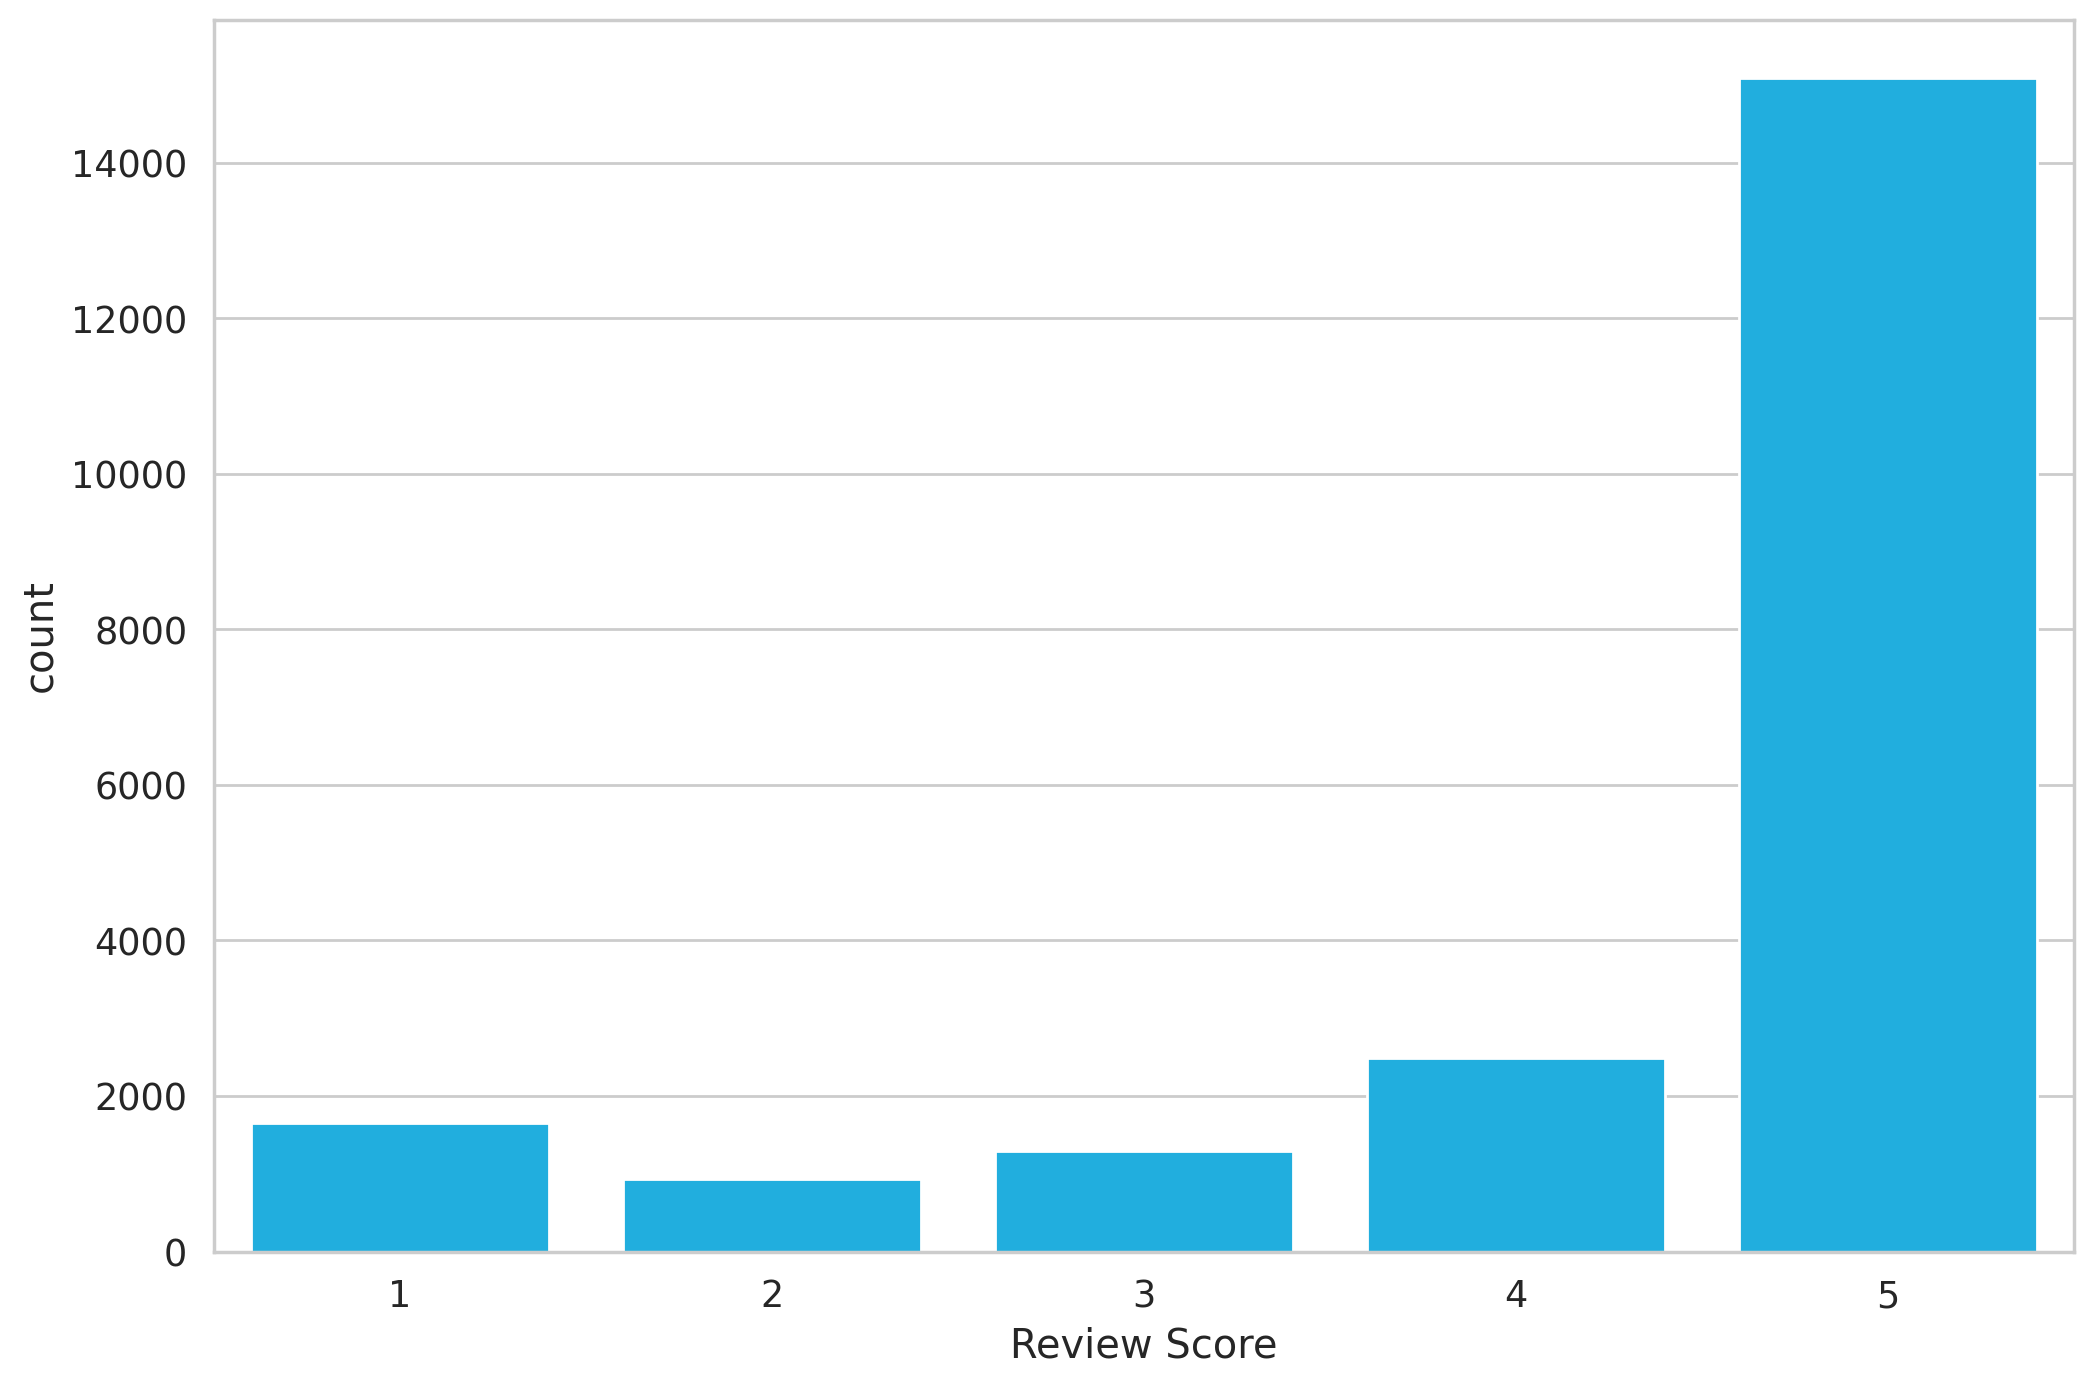

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'score' is the name of the column containing scores
sns.countplot(data=df, x='score')
plt.xlabel('Review Score')
plt.show()


In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

<ipython-input-7-4f49a5aa9551>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['negative', 'neutral', 'positive'])


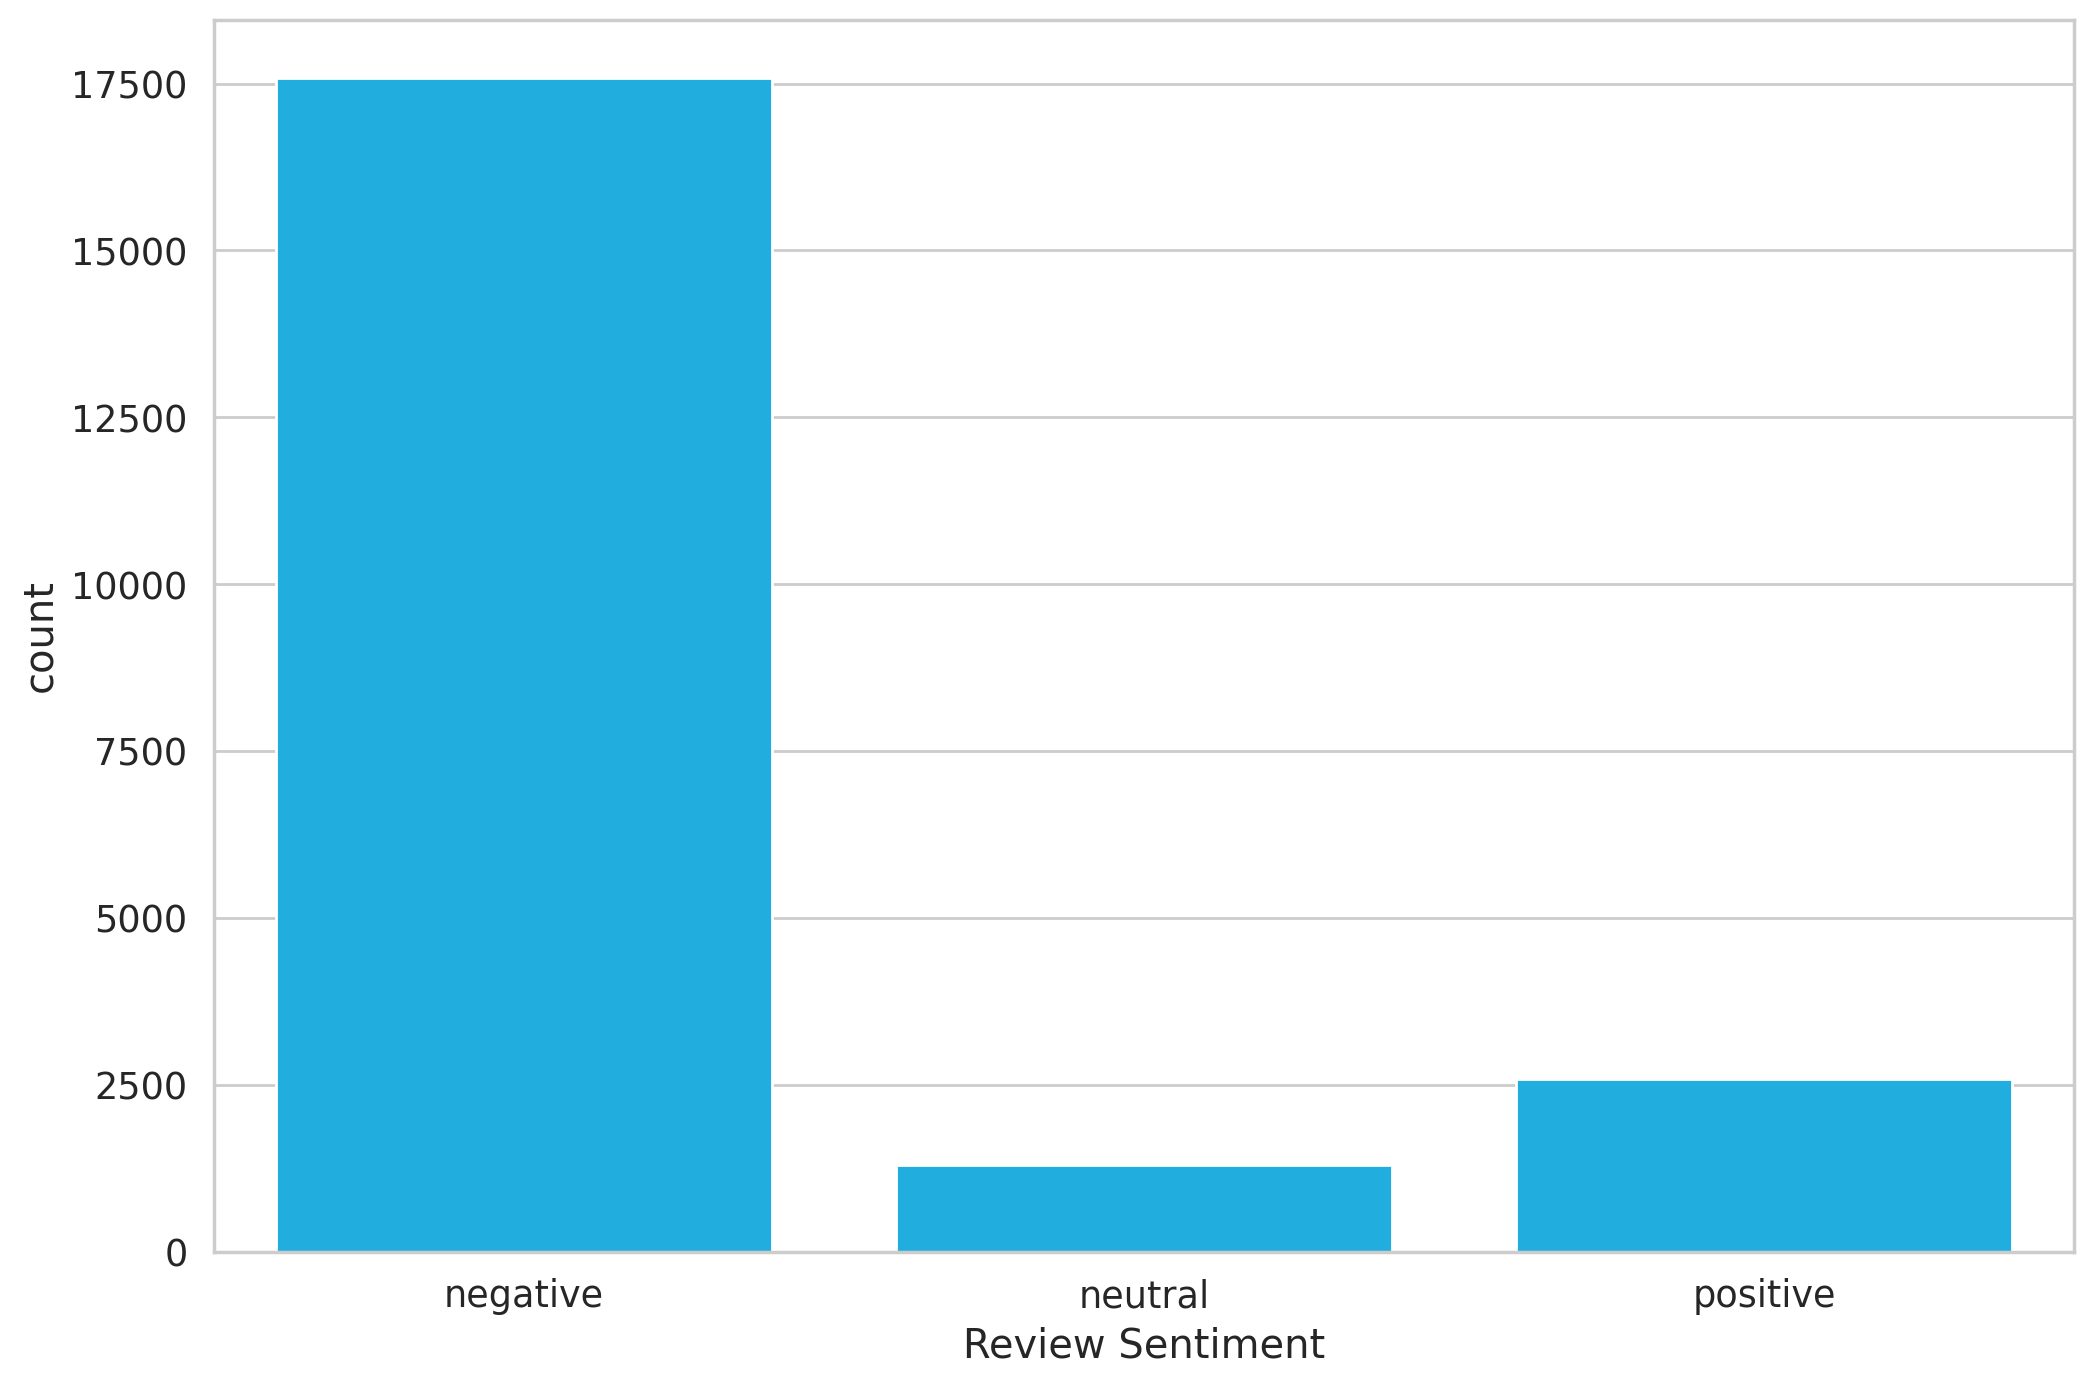

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'score' is the name of the column containing scores

def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

# Apply the to_sentiment function to the 'score' column to create a new 'sentiment' column
df['sentiment'] = df['score'].apply(to_sentiment)

# Plot the count of sentiments
ax = sns.countplot(data=df, x='sentiment')

# Set x-axis tick labels
ax.set_xticklabels(['negative', 'neutral', 'positive'])

plt.xlabel('Review Sentiment')
plt.show()


In [ ]:
!pip install transformers

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report

In [ ]:

df = pd.read_csv('/content/phnpe1.csv')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Select relevant columns
df = df[['content', 'score']]

# Convert scores to sentiment labels
df['sentiment'] = df['score'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))

# Convert sentiment labels to numerical values
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(label_map)
labels = torch.tensor(df['label'])


df = df.dropna(subset=['content'])

# Tokenize text and convert to input IDs
max_length = 128
input_ids = []
attention_masks = []

for review in df['content']:
    encoded_dict = tokenizer.encode_plus(
                        review,                      # Review text
                        add_special_tokens = True,  #
                        max_length = max_length,    # Pad & truncate all reviews to max_length
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True, # Construct attention masks
                        return_tensors = 'pt',      # Return pytorch tensors
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['label'])

<ipython-input-11-7bc0d4c06c1f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['score'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))


In [ ]:
# Split data into train and validation sets
# Split data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [ ]:
# Create dataloaders
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Fine-tune BERT
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Average training loss: 0.35
Average training loss: 0.25
Average training loss: 0.18
Average training loss: 0.13
Average training loss: 0.10
Average training loss: 0.07
Average training loss: 0.06
Average training loss: 0.05
Average training loss: 0.04
Average training loss: 0.04


In [ ]:
# Evaluation on validation set
model.eval()
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

predictions, true_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(np.argmax(logits, axis=1))
    true_labels.append(label_ids)

flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

print("Accuracy: {0:.2f}".format(accuracy_score(flat_true_labels, flat_predictions)))
print(classification_report(flat_true_labels, flat_predictions, target_names=['negative', 'neutral', 'positive']))


Accuracy: 0.89
              precision    recall  f1-score   support

    negative       0.74      0.69      0.72       504
     neutral       0.36      0.36      0.36       267
    positive       0.95      0.96      0.96      3522

    accuracy                           0.89      4293
   macro avg       0.68      0.67      0.68      4293
weighted avg       0.89      0.89      0.89      4293



In [ ]:
from transformers import BertForSequenceClassification

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)

# Print model summary
print(model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Import the pickle library
import pickle

# Open a file in binary write mode
with open('model.pkl', 'wb') as file:
    # Use pickle.dump to serialize the model and save it to the file
    pickle.dump(model, file)